# How to recover artifical signals from lightcurves

In addition to tools that inject artifical signals into Kepler, K2, and TESS lightcurves, `lightcurve` also includes tools to recover signals (real or injected).  In this notebook, we will recover signals of an injected supernova and an injected planet.

**SOME TEMPORARY NOTES:**

We want to be able to inject and recover with either a LightCurve object or a SyntheticLightCurve object.

So, do we want to put the "pointer" methods (the methods that live in the LightCurve or SyntheticLightCurve classes but point to lightkurve.injection) in both LC and SLC classes?

Right now, `.recover` is in SyntheticLightCurve and `.inject` is in LightCurve.

**ALSO: WRITE DOCSTRINGS!!!**


In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
import lightkurve.injection as inj
from lightkurve.lightcurve import SyntheticLightCurve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fitting a Supernova Signal

Let's download a TPF of a K2 galaxy and create the light curve.  We won't normalize it, because knowing the background flux is important in the fitting process.

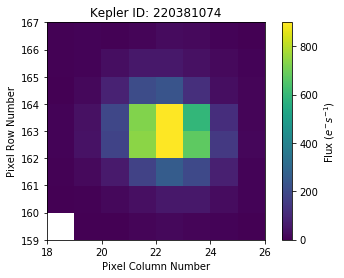

In [2]:
tpf = KeplerTargetPixelFile.from_archive(220381074) 
tpf.plot()

Text(0.5,1,'EPIC 220381074')

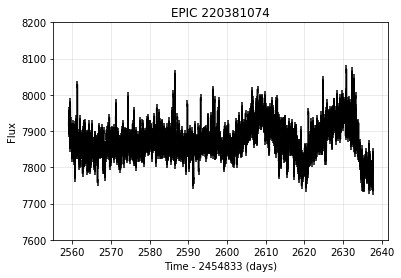

In [3]:
lc = tpf.to_lightcurve(aperture_mask='all')

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers() 

lc.plot(normalize=False)
plt.ylim(7600, 8200)
plt.title('EPIC 220381074')

Now let's create a supernova model using `injection.SupernovaModel` class, and inject it using the `.inject` method.

This supernova will peak in the middle of the lightcurve, have a redshift of 0.5, and an amplitude of 2e-7 e/s/cm^2.

In [16]:
from lightkurve.injection import SupernovaModel

In [17]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=2.e-7)

In [18]:
lcinj = lc.inject(model)

Let's plot the model by itself (by evaluating it over the initial lightcurve's timestamps):

Text(0,0.5,'Flux')

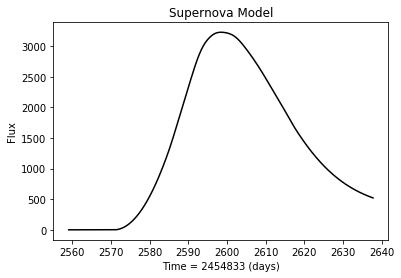

In [20]:
model_sn_eval = model.evaluate(lc.time)

plt.plot(lc.time, model_sn_eval, c='k')
plt.title('Supernova Model')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')

And now the model injected into our galaxy:

Text(0.5,1,'EPIC 220381074 With SN')

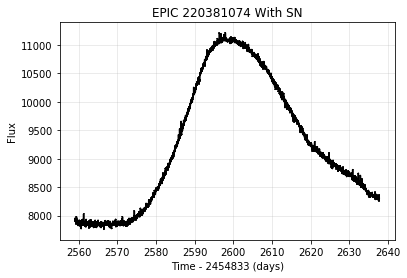

In [21]:
lcinj.plot(normalize=False)
plt.title('EPIC 220381074 With SN')

Now let's use the `.recover` method to recover the injected supernova with the keyword 'Supernova'.  For supernova fitting, we can specify an intitial guess, which is a vector of first guess parameters - in this case, [T0, z, amplitude, background].

In [22]:
x0 = [2610, 0.5, 2.0e-7, np.percentile(lc.flux, 3)]

In [23]:
%%time
T0_fit, z_fit, amplitude_fit, background_fit = lcinj.recover('Supernova', initial_guess=x0)

CPU times: user 48.9 s, sys: 6.86 s, total: 55.7 s
Wall time: 58.6 s


We can a new SupernovaModel object with the fitted parameters and overplot it with the injected lightcurve:

In [33]:
new_model = inj.SupernovaModel(T0=T0_fit, source='hsiao', bandpass='kepler', z=z_fit, amplitude=amplitude_fit)
new_fit = new_model.evaluate(lc.time) + background_fit

Text(0,0.5,'Flux')

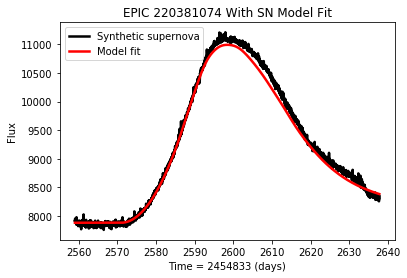

In [34]:
plt.plot(lcinj.time, lcinj.flux, label='Synthetic supernova', color='k', lw='2.5')
plt.plot(lcinj.time, new_fit, label = 'Model fit', color='r', lw='2.5')
plt.legend()
plt.title('EPIC 220381074 With SN Model Fit')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')

If we don't want to specify an initial guess, `.recover` will create a default initial guess.

In [35]:
T0_f, z_f, amplitude_f, background_f = lcinj.recover('Supernova')

In [52]:
new_model = inj.SupernovaModel(T0=T0_f, source='hsiao', bandpass='kepler', z=z_f, amplitude=amplitude_f)
new_fit = new_model.evaluate(lc.time) + background_f

Text(0,0.5,'Flux')

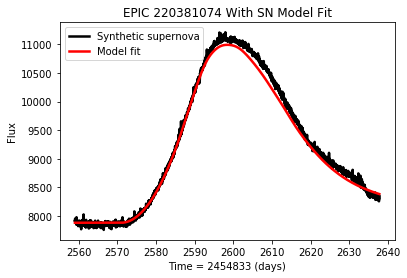

In [53]:
plt.plot(lcinj.time, lcinj.flux, label='Synthetic supernova', color='k', lw='2.5')
plt.plot(lcinj.time, new_fit, label = 'Model fit', color='r', lw='2.5')
plt.legend()
plt.title('EPIC 220381074 With SN Model Fit')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')

**Fitting supernovae with models that do not take amplitude: this is coming later.**

**TODO: figure out which values of z, x0, x1, and c (for SALT2 models) violate the Kepler bandpass.**

x0 = [2610, 0.5, 2.0e-3, 1.e-2, -.1, np.percentile(lc.flux, 3)]

%%time
T0_f, z_f, x0_f, x1_f, c_f, background_f = inj.recover(lcinj, 'Supernova', source='SALT2', initial_guess=x0)

new_model = inj.SupernovaModel(T0=T0_f, source='SALT2', bandpass='kepler', z=z_f, x0=x0_f, x1=x1_f, c=c_f)
new_fit = new_model.evaluate(lc.time) + background_f

# Fitting a Planetary Transit

Let's download a TPF and lightcurve of a G-type star from Kepler:

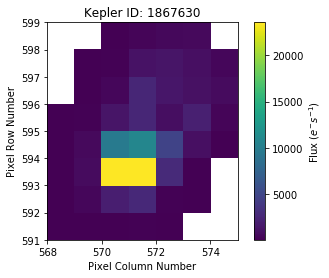

In [3]:
tpf_star = KeplerTargetPixelFile.from_archive(1867630, quarter=1)
tpf_star.plot()

In [4]:
lc_star = tpf_star.to_lightcurve(aperture_mask='all')

I am going to normalize this light curve, because we are multiplying in a normalized transit lightcurve.

Text(0.5,0,'Time (days)')

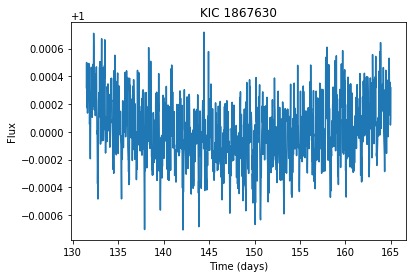

In [5]:
lc_star = lc_star.remove_nans().remove_outliers()
lc_star = lc_star.normalize()

plt.plot(lc_star.time, lc_star.flux)
plt.title('KIC 1867630')
plt.ylabel('Flux')
plt.xlabel('Time (days)')

Now I'm creating a lightcurve with `batman` of a Jupiter-sized planet with an orbital period of 5 days. **As soon as I get my computer back that runs ktransit I can use lc.inj to directly inject a lightkurve.  Or maybe I'll get it working on this computer. **

In [7]:
import batman

In [8]:
params = batman.TransitParams()
params.t0 = 133
params.per = 3.
params.rp = 0.15
params.a = 15.
params.inc = 90.
params.ecc = 0.
params.w = 90.
params.limb_dark = "nonlinear"
params.u = [0.5, 0.1, 0.1, -0.1]

#The parameters besides t0, per, and rp don't really matter for a 
#fitting example as long as we keep them consistent.  We're only
#fitting those three params.

t = lc_star.time.astype(np.float)  #BE CAREFUL - these time stamps need to be turned into floats (in batman)
m = batman.TransitModel(params, t)
flux = m.light_curve(params)  

Let's plot just the model:

Text(0.5,0,'Time (days)')

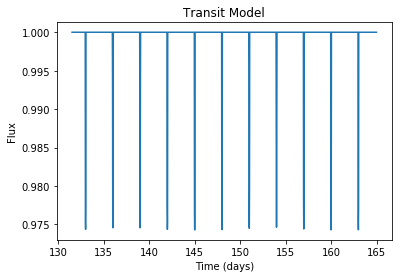

In [10]:
plt.plot(t, flux)
plt.title('Transit Model')
plt.ylabel('Flux')
plt.xlabel('Time (days)')

In [11]:
lcinj_time = lc_star.time
lcinj_flux = lc_star.flux * flux
lcinj_fluxerr = lc_star.flux_err

And now the injected lightcurve:

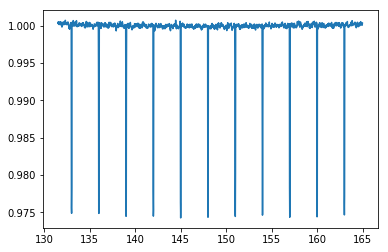

In [12]:
plt.plot(lcinj_time, lcinj_flux)

I'm going to make this a SyntheticLightCurve object (temporary, since we're using `batman`), so we can pass it into the `.recover` method.

In [15]:
lcinj = SyntheticLightCurve(time=lcinj_time, flux=lcinj_flux, flux_err=lcinj_fluxerr)

Now let's recover the transits using the `.recover` method with the signaltype 'Planet'.

In [19]:
period_fit, rprs_fit, T0_fit = lcinj.recover('Planet')

Let's create a new model with these parameters and overplot with the injected signal.

In [20]:
params = batman.TransitParams()
params.t0 = T0_fit
params.per = period_fit
params.rp = rprs_fit
params.a = 15.
params.inc = 90.
params.ecc = 0.
params.w = 90.
params.limb_dark = "nonlinear"
params.u = [0.5, 0.1, 0.1, -0.1]

t = lc_star.time.astype(np.float)
m_fit = batman.TransitModel(params, t, fac=1.0)
flux_fit = m.light_curve(params)

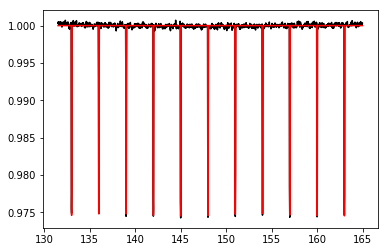

In [21]:
plt.plot(lcinj_time, lcinj_flux, color='k')
plt.plot(t, flux_fit, color='r')

# Work in progress: recovering multiple planets

What if we want to recover more than one planet?

In [22]:
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 134                   #time of inferior conjunction
params.per = 8                     #orbital period
params.rp = 0.07                    #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 90.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = lc_star.time.astype(np.float)  #times at which to calculate light curve
m = batman.TransitModel(params, t, fac=1.0)    #initializes model
flux_2 = m.light_curve(params)

In [23]:
flux_mult = lc_star.flux * flux * flux_2

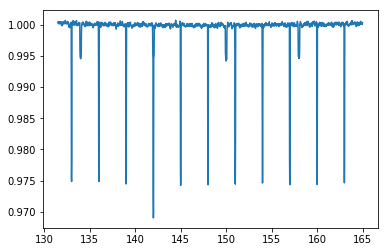

In [24]:
plt.plot(t, flux_mult)

In [25]:
from astropy.stats import BLS

In [26]:
model = BLS(t, flux_mult, dy=0.01)

In [27]:
periodogram = model.autopower(0.2)

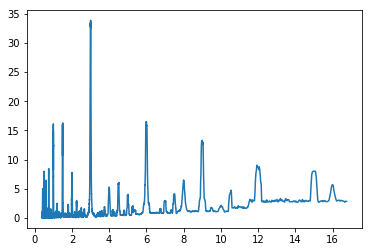

In [28]:
plt.plot(periodogram.period, periodogram.power)

Hmmmm.....

In [33]:
model = inj.TransitModel()

ImportError: dlopen(/Users/gull/anaconda3/lib/python3.6/site-packages/ktransit/_tmodtom.cpython-36m-darwin.so, 2): Symbol not found: __gfortran_internal_free
  Referenced from: /Users/gull/anaconda3/lib/python3.6/site-packages/ktransit/_tmodtom.cpython-36m-darwin.so
  Expected in: dynamic lookup
